<a href="https://colab.research.google.com/github/janaksunil/doordash-eta-predictor/blob/main/Group_Poject_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**First Start with Preprocessing**

#Convert the timestamp features to datetime objects
This is done for ease of doing arithmetic operations, an example being calculating the differences between dates and times. In our case we can calculate the total delivery duration by subtracting the order creation time from the delivery time. Overall converting the timestamps to datetime objects allows for accurate time based calculations.

#Remove the timestamp features
This was done, since 'total_delivery_duration' encompases all the information needed about the time span between when the order is created and delivered.

#Drop rows with any missing values
This was a personal choice as i felt it was not a good idea to get the average of what type of food people are ordering, for example taking the average of mexican food and american food would not make sense to take this average and have it generate a new food type based on this data. Instead we simply drop the data.

#Separate features and target
Features X = our input variables that the model will use to make predictions, here are the data points that will provide information so the model learns patterns and relationships. Y = the target, which is the output variable that the model is trying to predict for our data the target variable is 'total_delivery_duration' which shows the total delivery duration in seconds.

#Column transfer for preprocessing
'ColumnTransformer' is used to apply different preprocessing steps to the numeric and categorical features. It combines the preprocessed features into a single dataset that can be used for model training.

#Fill in missing data using the median
Due to the graph of the data being skewed to the right, it means that the median may be better use and that there are also potential outliers. Therefore, for some data we have replaced it with the median value if it was missing.

#Eliminate Outliers
We identify and remove outliers based on the interquartile range (IQR) method. For each numeric feature, we calculate the IQR, which is the difference between the 75th and 25th percentiles. We then define a threshold of 1.5 times the IQR below the first quartile and above the third quartile. Any data points outside this range are considered outliers and are removed from the dataset.

#One-hot encoding
The dataset contains both categorical and numeric features, which require different preprocessing techniques. For categorical features, we apply one-hot encoding using the OneHotEncoder from scikit-learn. This creates binary dummy variables for each category, allowing the models to interpret categorical data. For numeric features, we apply standardization using the StandardScaler, which subtracts the mean and scales the values to unit variance. This helps the models converge faster and prevents features with larger magnitudes from dominating the learning process. We use the ColumnTransformer to apply these transformations to the respective columns conveniently.

#Split data into training sets
Prevents overfitting by evaluating the model on a separate test set.

In [ ]:
import pandas as pd

# Load data file
file_path = 'historical_data.csv'
data = pd.read_csv(file_path)
print(len(data))
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

data['delivery_duration_minutes'] = ((data['actual_delivery_time'] - data['created_at']).dt.total_seconds())/60

data.dropna(subset=['delivery_duration_minutes'], inplace=True)

data.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column].fillna(data[column].median(), inplace=True)
for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna('', inplace=True)

data['total_busy_dashers'] = abs(data['total_busy_dashers'])
data['total_onshift_dashers'] = abs(data['total_onshift_dashers'])

data = data[data['total_onshift_dashers'] != 0]

data['dashers_availability_percent'] = ((data['total_onshift_dashers'] - data['total_busy_dashers'])/data['total_onshift_dashers'])*100



197428


<ipython-input-1-cbc24f7218fc>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dashers_availability_percent'] = ((data['total_onshift_dashers'] - data['total_busy_dashers'])/data['total_onshift_dashers'])*100


In [ ]:
#now need to remove outliers
len_before_outliers = len(data)

def find_outliers(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    df = df[(df[variable] > lower_boundary) &  (df[variable] < upper_boundary)]

    return df

data = find_outliers(data, 'subtotal', 1.5).sort_values(by = ['subtotal'])
data = find_outliers(data, 'delivery_duration_minutes', 1.5).sort_values(by = ['delivery_duration_minutes'])
data = find_outliers(data, 'max_item_price', 1.5).sort_values(by = ['delivery_duration_minutes'])

print(f"Length Before Outliers: {len_before_outliers}")
print(f"Length after Outliers Dropped: {len(data)}")

Length Before Outliers: 193806
Length after Outliers Dropped: 172397


In [ ]:
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)

le = LabelEncoder()

for cat_var in ['store_id','store_primary_category']:
    data[cat_var] = le.fit_transform(data[cat_var])




In [ ]:
data = data.dropna(how='any',axis=0)

In [ ]:
data.columns #viewing what columns we have

Index(['market_id', 'store_id', 'store_primary_category', 'order_protocol',
       'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'delivery_duration_minutes', 'dashers_availability_percent'],
      dtype='object')

In [ ]:
data = data.drop(columns = ['min_item_price','num_distinct_items','order_protocol',
                            'total_onshift_dashers','total_busy_dashers'])

In [ ]:
data.to_csv('cleaned_data.csv', index=False)

In [ ]:
#Fully Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

data = pd.read_csv('cleaned_data.csv')

X = data.drop(columns=['delivery_duration_minutes'])
y = data['delivery_duration_minutes']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(X_train.shape, X_test.shape)

(137917, 10) (34480, 10)


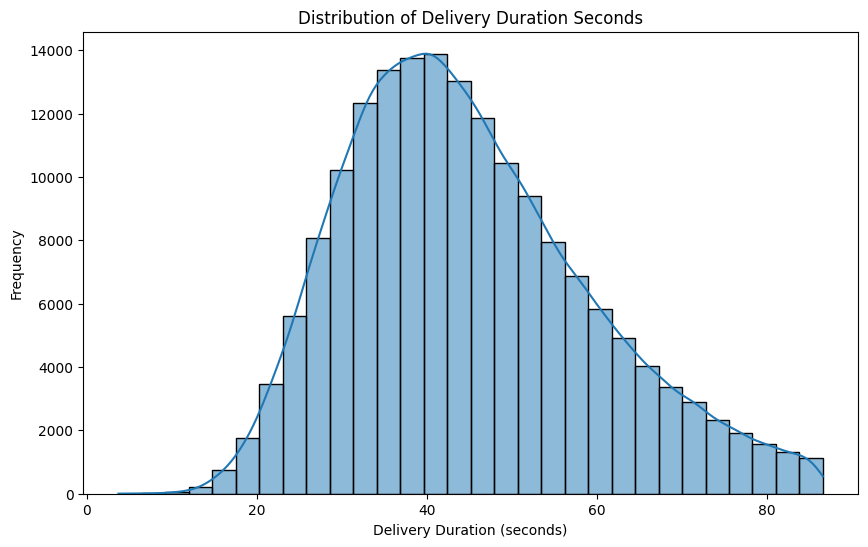

<Figure size 1500x1000 with 0 Axes>

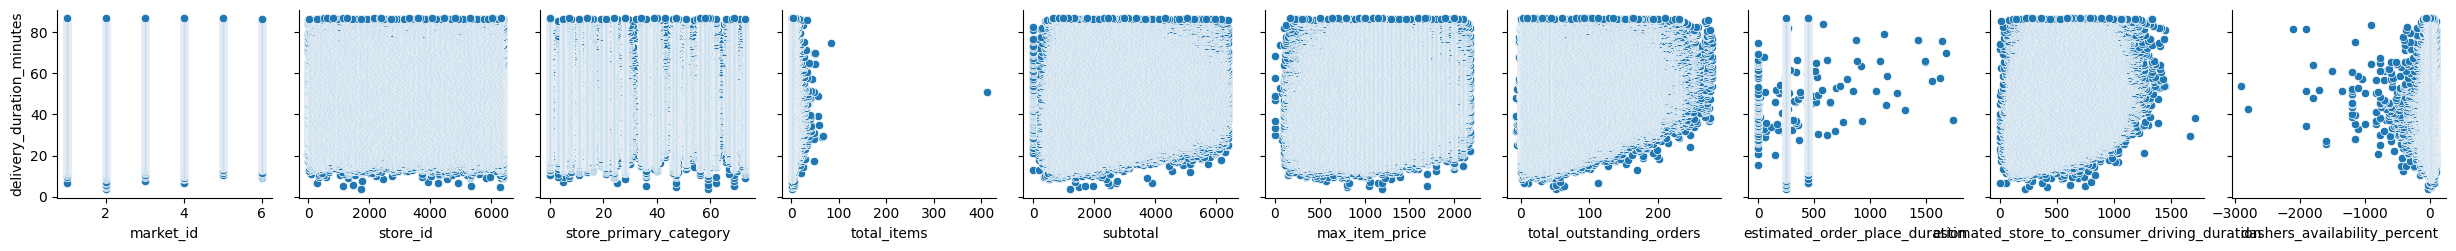

In [ ]:
#Let's graph some data
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
data = pd.read_csv('cleaned_data.csv')

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['delivery_duration_minutes'], bins=30, kde=True)
plt.title('Distribution of Delivery Duration Seconds')
plt.xlabel('Delivery Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Plot relationships between numerical features and target
plt.figure(figsize=(15, 10))
sns.pairplot(data, y_vars='delivery_duration_minutes', x_vars=numerical_features)
plt.show()

#Start of the Model Training and Evaluation of Polynomial Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Function to evaluate polynomial regression models
def evaluate_polynomial_regression(degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_train_poly = polynomial_features.fit_transform(X_train)
    X_test_poly = polynomial_features.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    print(f"Degree {degree}")
    print(f"Train RMSE: {mean_squared_error(y_train, y_train_pred, squared=False)}")
    print(f"Train R2: {r2_score(y_train, y_train_pred)}")
    print(f"Test RMSE: {mean_squared_error(y_test, y_test_pred, squared=False)}")
    print(f"Test R2: {r2_score(y_test, y_test_pred)}")
    print("\n")

# Evaluate models with degrees 1, 2, 3, and 4
for degree in [1, 2, 3, 4]:
    evaluate_polynomial_regression(degree)

Degree 1
Train RMSE: 13.203227913859605
Train R2: 0.1603436722797349
Test RMSE: 13.214664836996615
Test R2: 0.1583669187668233


Degree 2
Train RMSE: 13.026331997274474
Train R2: 0.18269226272177086
Test RMSE: 13.057229016766552
Test R2: 0.17830142230587742


Degree 3
Train RMSE: 12.87820456751595
Train R2: 0.20117441904779598
Test RMSE: 14.551292383518952
Test R2: -0.020501451394149717


Degree 4
Train RMSE: 12.748768542683246
Train R2: 0.21715136642646227
Test RMSE: 30.639306013566202
Test R2: -3.524476540470495




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.65806e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


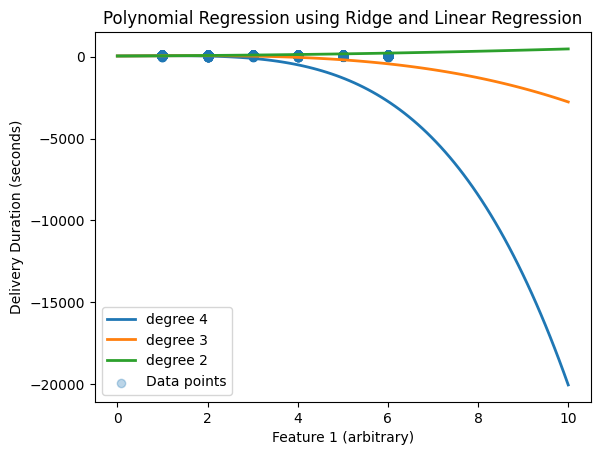

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression
import matplotlib.pyplot as plt


x_plot = np.linspace(0, 10, 100).reshape(-1, 1)

# Fit polynomial regression models
poly1 = make_pipeline(PolynomialFeatures(2), Ridge()) # degree 2
poly1.fit(X_train, y_train)
y_plot1 = poly1.predict(np.hstack([x_plot]*10))

poly2 = make_pipeline(PolynomialFeatures(3), LinearRegression()) # degree 3
poly2.fit(X_train, y_train)
y_plot2 = poly2.predict(np.hstack([x_plot]*10))

poly3 = make_pipeline(PolynomialFeatures(4), Ridge()) # degree 4
poly3.fit(X_train, y_train)
y_plot3 = poly3.predict(np.hstack([x_plot]*10))

# Plot the results
plt.plot(x_plot, y_plot3, linewidth=2, label="degree 4")
plt.plot(x_plot, y_plot2, linewidth=2, label="degree 3")
plt.plot(x_plot, y_plot1, linewidth=2, label="degree 2")
plt.scatter(X.iloc[:, 0], y, alpha=0.3, label='Data points')
plt.title('Polynomial Regression using Ridge and Linear Regression')
plt.xlabel('Feature 1 (arbitrary)')
plt.ylabel('Delivery Duration (seconds)')
plt.legend(loc='lower left')
plt.show()

#Now for the Neural Network#

In [ ]:
file_path = 'historical_data_2.csv'
data_2 = pd.read_csv(file_path)

In [ ]:
data_2['created_at'] = pd.to_datetime(data_2['created_at'])
data_2['actual_delivery_time'] = pd.to_datetime(data_2['actual_delivery_time'])

data_2['delivery_duration_minutes'] = ((data_2['actual_delivery_time'] - data_2['created_at']).dt.total_seconds()) /60

data_2.dropna(subset=['delivery_duration_minutes'], inplace=True)

data_2.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

data_2 = data_2.dropna()

data_2 = data_2[data_2['total_onshift_dashers'] > 0]
data_2 = data_2[data_2['total_busy_dashers'] > 0]
data_2 = data_2[data_2['total_busy_dashers'] <= data_2['total_onshift_dashers']]

data_2 = data_2[data_2['max_item_price'] > 0]
data_2 = data_2[data_2['min_item_price'] >= 0]

data_2 = data_2[data_2['total_outstanding_orders'] >= 0]

data_2['dashers_availability_percent'] = ((data_2['total_onshift_dashers'] - data_2['total_busy_dashers'])/data_2['total_onshift_dashers'])*100

data_2['delivery_duration_minutes'] = data_2['delivery_duration_minutes'].astype(int)



In [ ]:
#removing some outliers
len_before_outliers = len(data_2)

data_2 = find_outliers(data_2, 'subtotal', 1.5).sort_values(by = ['subtotal'])
data_2 = find_outliers(data_2, 'delivery_duration_minutes', 1.5).sort_values(by = ['delivery_duration_minutes'])
data_2 = find_outliers(data_2, 'max_item_price', 1.5).sort_values(by = ['delivery_duration_minutes'])
data_2 = find_outliers(data_2, 'min_item_price', 1.5).sort_values(by = ['delivery_duration_minutes'])

print(f"Length Before Outliers: {len_before_outliers}")
print(f"Length after Outliers Dropped: {len(data_2)}")


Length Before Outliers: 132372
Length after Outliers Dropped: 116466


In [ ]:
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)

le = LabelEncoder()

for cat_var in ['store_id','store_primary_category']:
    data_2[cat_var] = le.fit_transform(data_2[cat_var])

data_2 = data_2.drop(columns = ['min_item_price','num_distinct_items','order_protocol',
                            'total_onshift_dashers','total_busy_dashers'])



In [ ]:
print(data_2)

        market_id  store_id  store_primary_category  total_items  subtotal  \
42507         2.0       909                      67            1      1700   
158816        2.0       229                      45            4      2722   
62781         4.0      3421                      60            5      3900   
91844         1.0      3966                      24            6      2440   
78374         3.0      1401                      67            6      2750   
...           ...       ...                     ...          ...       ...   
6926          2.0      5138                      13            3      1775   
171818        4.0      3219                      56            2      2175   
115420        5.0       535                      57            1      1248   
41213         5.0      2318                      23            1      1500   
178122        3.0      1390                      10            4      3580   

        max_item_price  total_outstanding_orders  \
42507      

In [ ]:
  #Preprocess again
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  from sklearn.compose import ColumnTransformer
  import numpy as np
  # Drop the target variable from X
  X = data_2.drop(columns=['delivery_duration_minutes'])
  y = data_2['delivery_duration_minutes']

  # Define numerical features (excluding 'store_id')
  numerical_features = [
      'total_items',
      'subtotal',
      'max_item_price',
      'total_outstanding_orders',
      'estimated_order_place_duration',
      'estimated_store_to_consumer_driving_duration',
      'dashers_availability_percent'
  ]

  # Select features to use
  selected_features = [
      'store_id',
      'total_items',
      'subtotal',
      'max_item_price',
      'total_outstanding_orders',
      'estimated_order_place_duration',
      'estimated_store_to_consumer_driving_duration',
      'dashers_availability_percent'
  ]

  X = X[selected_features]

  # Define numerical transformer
  numerical_transformer = StandardScaler()

  # Define preprocessor to only scale the numerical features
  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numerical_transformer, numerical_features)
      ],
      remainder='drop'  # Drop other columns (including store_id) during transformation
  )

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Extract the store_id column separately
  store_id_train = X_train['store_id'].values.reshape(-1, 1)
  store_id_test = X_test['store_id'].values.reshape(-1, 1)

  # Drop the store_id column from X_train and X_test before transformation
  X_train = X_train.drop(columns=['store_id'])
  X_test = X_test.drop(columns=['store_id'])

  # Apply the transformations to the remaining features
  X_train_scaled = preprocessor.fit_transform(X_train)
  X_test_scaled = preprocessor.transform(X_test)

  # Combine the unscaled store_id back with the scaled features
  X_train_final = np.hstack((store_id_train, X_train_scaled))
  X_test_final = np.hstack((store_id_test, X_test_scaled))

  # Optionally convert to lists (though numpy arrays might be more practical)
  X_train = X_train_final.tolist()
  X_test = X_test_final.tolist()

  # Print variance of y_train
  print(y_train.var())

  # If needed, print the shape of X_train_final and X_test_final
  print(len(X_train_final), len(X_test_final))

194.78118865185272
93172 23294


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CyclicLR

In [ ]:
device = torch.device("cuda" if torch.cuda .is_available() else 'cpu')
print(f'Using device: {device}')

# Convert to PyTorch tensors
input_tensor_train = torch.tensor(X_train).float().to(device)
input_tensor_test = torch.tensor(X_test).float().to(device)
output_tensor_train = torch.tensor(y_train.values).float().to(device)
output_tensor_test = torch.tensor(y_test.values).float().to(device)
# output_tensor_train = torch.log(output_tensor_train)
print(input_tensor_train.shape)

Using device: cuda
torch.Size([93172, 8])


In [ ]:
print(input_tensor_train[100])

tensor([ 3.1770e+03, -4.0611e-01, -4.1204e-01, -4.1879e-01,  4.0975e+00,
        -6.2160e-01,  1.2105e+00, -5.0845e-01], device='cuda:0')


In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, output_size, hidden_size):
    super(MLP,self).__init__()
    self.embedding2 = nn.Embedding(num_embeddings=X['store_id'].nunique(), embedding_dim=45)
    self.layer1 = nn.Linear(input_size + 45, hidden_size)
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.layer3 = nn.Linear(hidden_size, hidden_size)
    self.layer4 = nn.Linear(hidden_size, hidden_size)
    self.layer5 = nn.Linear(hidden_size, hidden_size)
    self.layer6 = nn.Linear(hidden_size, hidden_size)
    self.layer7 = nn.Linear(hidden_size, hidden_size)
    self.layer8 = nn.Linear(hidden_size, hidden_size)
    self.layer9 = nn.Linear(hidden_size, hidden_size)
    self.layer_last = nn.Linear(hidden_size, output_size)
    self.bn1 = nn.BatchNorm1d(hidden_size)
    self.bn2 = nn.BatchNorm1d(hidden_size)
    self.bn3 = nn.BatchNorm1d(hidden_size)
    self.bn4 = nn.BatchNorm1d(hidden_size)
    self.bn5 = nn.BatchNorm1d(hidden_size)
    self.bn6 = nn.BatchNorm1d(hidden_size)
    self.bn7 = nn.BatchNorm1d(hidden_size)
    self.bn8 = nn.BatchNorm1d(hidden_size)
    self.bn9 = nn.BatchNorm1d(hidden_size)
    self._initialize_weights()
    self.activation = nn.GELU()
    self.dropout1 = nn.Dropout(0.1)

  def _initialize_weights(self):
    nn.init.kaiming_uniform_(self.layer1.weight)
    nn.init.kaiming_uniform_(self.layer2.weight)
    nn.init.kaiming_uniform_(self.layer3.weight)
    nn.init.kaiming_uniform_(self.layer4.weight)
    nn.init.kaiming_uniform_(self.layer5.weight)
    nn.init.kaiming_uniform_(self.layer6.weight)
    nn.init.kaiming_uniform_(self.layer7.weight)
    nn.init.kaiming_uniform_(self.layer8.weight)
    nn.init.kaiming_uniform_(self.layer9.weight)
    nn.init.kaiming_uniform_(self.layer_last.weight)

  def forward(self,x):
    embedded2 = self.embedding2(x[:, 0].long())
    # Concatenate embeddings with the rest of the input features
    x = torch.cat([embedded2, x[:, 1:]], dim=1)
    x = self.activation(self.bn1(self.layer1(x)))
    x = self.activation(self.bn2(self.layer2(x)))
    identity = x
    x = self.activation(self.bn3(self.layer3(x)))
    x=self.dropout1(x)
    x = self.activation(self.bn4(self.layer4(x)))
    x += identity # residual connection
    x = self.activation(self.bn5(self.layer5(x)))
    identity2 = x
    x = self.activation(self.bn6(self.layer6(x)))
    x = self.activation(self.bn7(self.layer7(x)))
    x += identity2 # residual connection
    x = self.activation(self.bn8(self.layer8(x)))
    x = self.activation(self.bn9(self.layer9(x)))
    x = self.layer_last(x)
    return x

In [ ]:
input_size = 7
output_size = 1
hidden_size = 100
model = MLP(input_size, output_size, hidden_size).to(device)

In [ ]:
def custom_loss(pred,truth):
  loss_function = nn.SmoothL1Loss()
  return loss_function(pred,truth) * truth / pred

In [ ]:
loss_function = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.0001,weight_decay=1e-4)
output_tensor_train = output_tensor_train.view(-1, 1)

num_epochs = 100000
model.train()
for epoch in range(num_epochs):
  outputs_pred = model(input_tensor_train)
  train_loss = loss_function(outputs_pred, output_tensor_train)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()
  if (epoch+1) % 100 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.10f}')

Epoch [100/100000], Train Loss: 1972.6132812500
Epoch [200/100000], Train Loss: 1883.3767089844
Epoch [300/100000], Train Loss: 1825.8238525391
Epoch [400/100000], Train Loss: 1776.0959472656
Epoch [500/100000], Train Loss: 1733.4855957031
Epoch [600/100000], Train Loss: 1692.0042724609
Epoch [700/100000], Train Loss: 1651.2916259766
Epoch [800/100000], Train Loss: 1611.2678222656
Epoch [900/100000], Train Loss: 1571.2238769531
Epoch [1000/100000], Train Loss: 1531.2108154297
Epoch [1100/100000], Train Loss: 1491.2479248047
Epoch [1200/100000], Train Loss: 1451.3154296875
Epoch [1300/100000], Train Loss: 1410.1934814453
Epoch [1400/100000], Train Loss: 1368.7399902344
Epoch [1500/100000], Train Loss: 1327.3183593750
Epoch [1600/100000], Train Loss: 1286.3178710938
Epoch [1700/100000], Train Loss: 1245.5633544922
Epoch [1800/100000], Train Loss: 1204.5654296875
Epoch [1900/100000], Train Loss: 1164.0681152344
Epoch [2000/100000], Train Loss: 1124.4635009766
Epoch [2100/100000], Train Lo

In [ ]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
      test_outputs_pred = model(input_tensor_test)
      test_loss = loss_function(test_outputs_pred, output_tensor_test.view(-1, 1))
print(f'test loss is: {test_loss}')

NameError: name 'loss_function' is not defined

Mean Squared Error: 396.5628
Mean Absolute Error: 15.3975
R-squared: -1.0470
Correlation between Residuals and Predicted Values: -0.7393
P-value: 0.0000


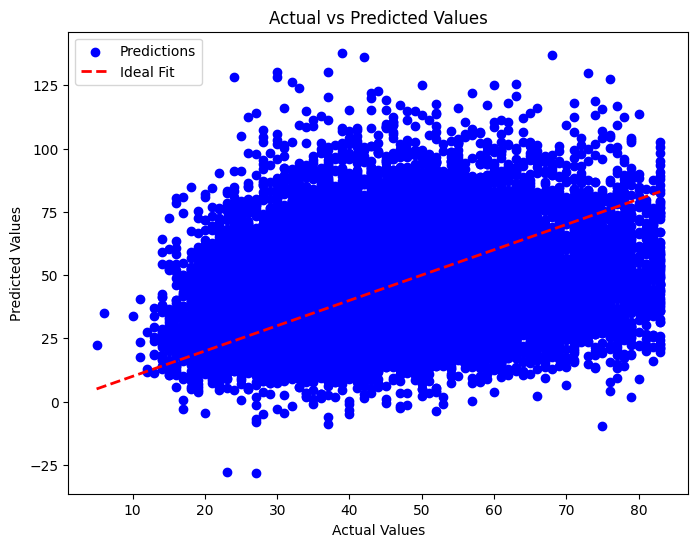

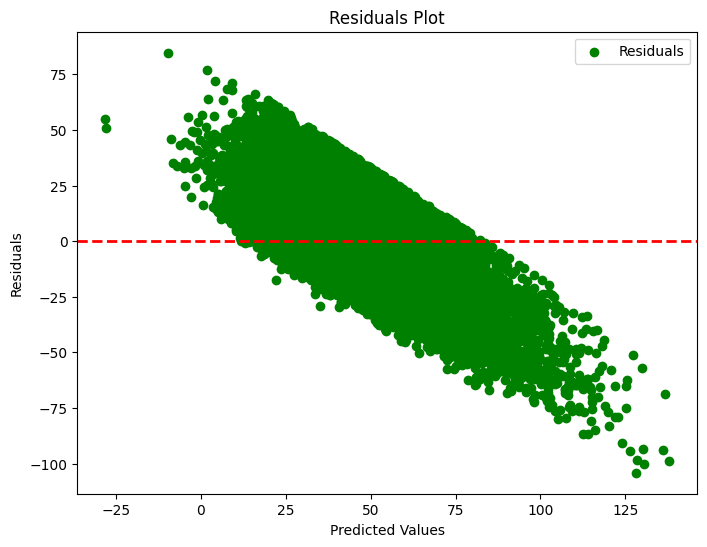

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr


model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Get predictions on the test set
    predictions = model(input_tensor_test)

# Convert tensors to numpy arrays for plotting
predictions_np = predictions.cpu().numpy()
output_test_np = output_tensor_test.cpu().numpy()

# Ensure shapes are matching
if predictions_np.shape != output_test_np.shape:
    predictions_np = predictions_np.reshape(-1)
    output_test_np = output_test_np.reshape(-1)

# Calculate residuals
residuals = output_test_np - predictions_np

# Calculate metrics
mse = mean_squared_error(output_test_np, predictions_np)
mae = mean_absolute_error(output_test_np, predictions_np)
r2 = r2_score(output_test_np, predictions_np)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

# Calculate the correlation between residuals and predicted values
correlation, p_value = pearsonr(predictions_np, residuals)
print(f"Correlation between Residuals and Predicted Values: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Plotting predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(output_test_np, predictions_np, color='blue', label='Predictions')
plt.plot([output_test_np.min(), output_test_np.max()], [output_test_np.min(), output_test_np.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

# Plotting residuals (errors)
plt.figure(figsize=(8, 6))
plt.scatter(predictions_np, residuals, color='green', label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()
plt.show()


Mean Squared Error: 0.3039
Mean Absolute Error: 0.2978
R-squared: 0.9984


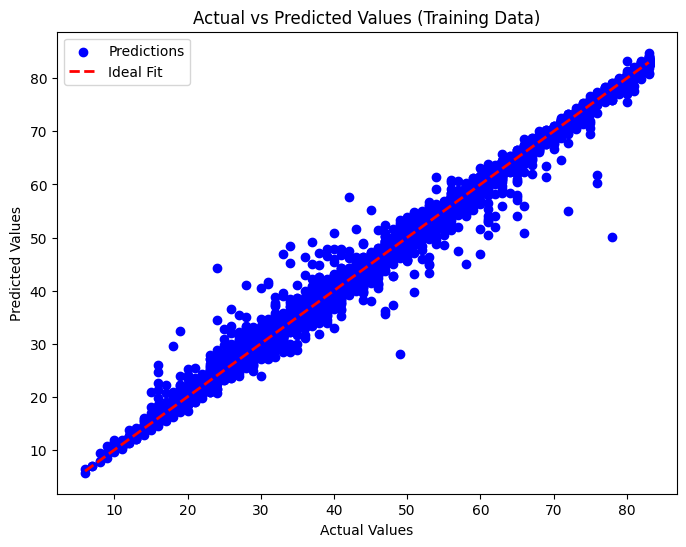

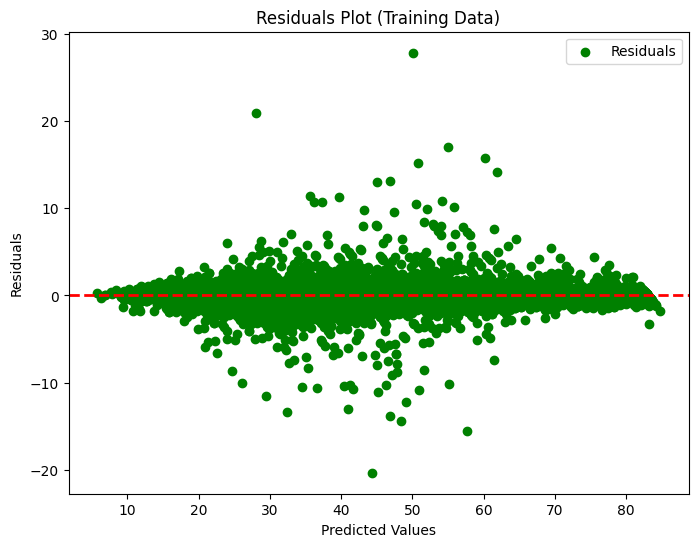

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Get predictions on the training set
    predictions = model(input_tensor_train)

# Convert tensors to numpy arrays for plotting
predictions_np = predictions.cpu().numpy()
output_train_np = output_tensor_train.cpu().numpy()

# Ensure shapes are matching
if predictions_np.shape != output_train_np.shape:
    predictions_np = predictions_np.reshape(-1)
    output_train_np = output_train_np.reshape(-1)

# Calculate residuals
residuals = output_train_np - predictions_np

# Calculate metrics
mse = mean_squared_error(output_train_np, predictions_np)
mae = mean_absolute_error(output_train_np, predictions_np)
r2 = r2_score(output_train_np, predictions_np)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

# Plotting predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(output_train_np, predictions_np, color='blue', label='Predictions')
plt.plot([output_train_np.min(), output_train_np.max()], [output_train_np.min(), output_train_np.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Training Data)')
plt.legend()
plt.show()

# Plotting residuals (errors)
plt.figure(figsize=(8, 6))
plt.scatter(predictions_np, residuals, color='green', label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot (Training Data)')
plt.legend()
plt.show()
